In [0]:
# #colabを使う方はこちらを使用ください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install pillow==5.0.0
# !pip install opencv-python==3.4.3.18

# CIFAR-10を畳み込みニューラルネットで画像分類

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=False, 
                                             transform=transforms.ToTensor(),
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)

In [0]:
num_classes = 10

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [6]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)

In [7]:
num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      #view()での変換をしない
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        #view()での変換をしない
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/20], Loss: 0.0344, val_loss: 0.0312, val_acc: 0.2420
Epoch [2/20], Loss: 0.0277, val_loss: 0.0258, val_acc: 0.3941
Epoch [3/20], Loss: 0.0235, val_loss: 0.0219, val_acc: 0.4862
Epoch [4/20], Loss: 0.0213, val_loss: 0.0210, val_acc: 0.5161
Epoch [5/20], Loss: 0.0196, val_loss: 0.0194, val_acc: 0.5529
Epoch [6/20], Loss: 0.0181, val_loss: 0.0185, val_acc: 0.5754
Epoch [7/20], Loss: 0.0166, val_loss: 0.0176, val_acc: 0.6117
Epoch [8/20], Loss: 0.0155, val_loss: 0.0175, val_acc: 0.6059
Epoch [9/20], Loss: 0.0144, val_loss: 0.0176, val_acc: 0.6235
Epoch [10/20], Loss: 0.0132, val_loss: 0.0175, val_acc: 0.6154
Epoch [11/20], Loss: 0.0122, val_loss: 0.0168, val_acc: 0.6346
Epoch [12/20], Loss: 0.0110, val_loss: 0.0177, val_acc: 0.6176
Epoch [13/20], Loss: 0.0101, val_loss: 0.0168, val_acc: 0.6482
Epoch [14/20], Loss: 0.0091, val_loss: 0.0172, val_acc: 0.6496
Epoch [15/20], Loss: 0.0083, val_loss: 0.0175, val_acc: 0.6480
Epoch [16/20], Loss: 0.0076, val_loss: 0.0187, val_acc: 0.6428
E

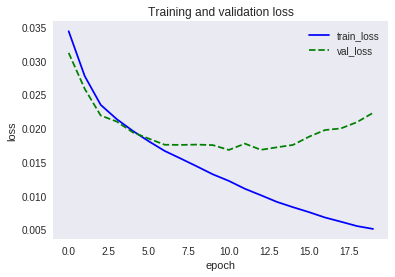

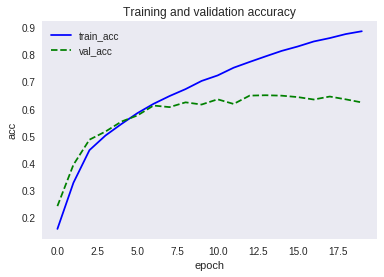

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()